Selected Features: ['DOSE', 'ADDL', 'D25BASE', 'Skin Type (Fitzpatrick Scale)']
🔹 Decision Tree Accuracy: 96.12%
🔹 Random Forest Accuracy: 95.65%
🔹 Decision Tree MSE: 200.9400, MAE: 6.7176, R²: 0.9612
🔹 Random Forest MSE: 225.6146, MAE: 9.7807, R²: 0.9565


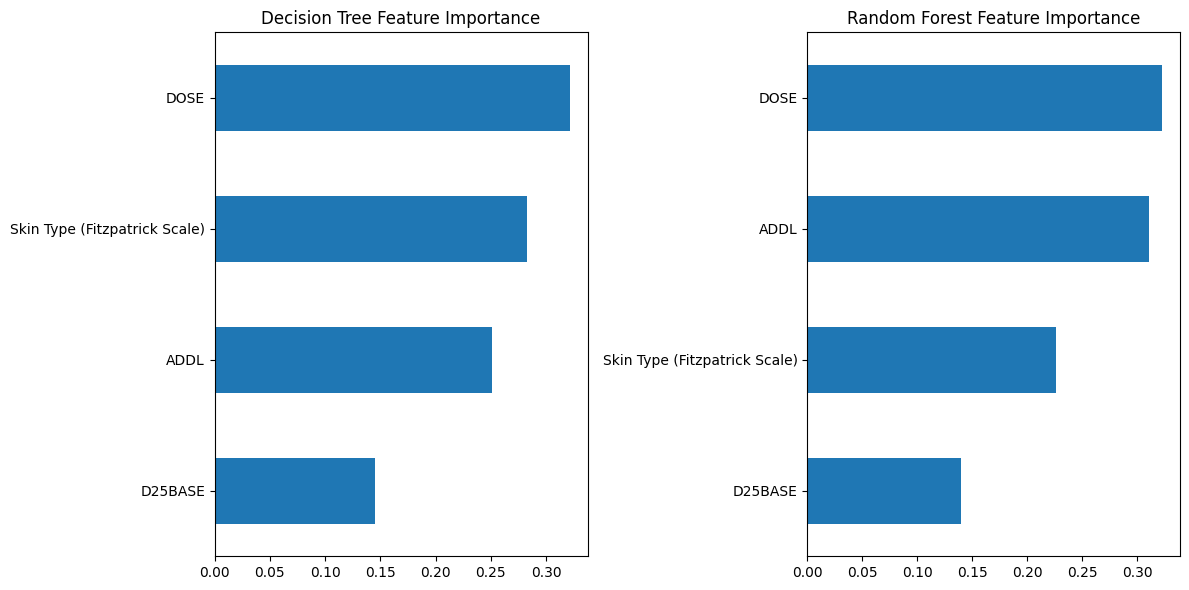

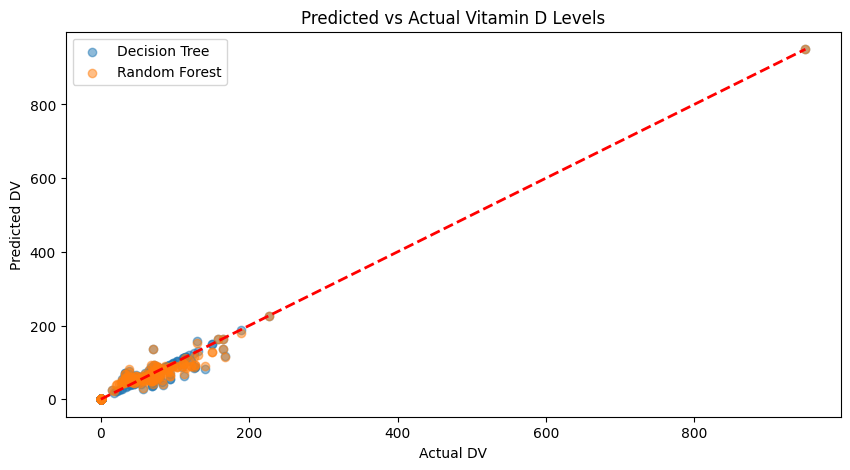

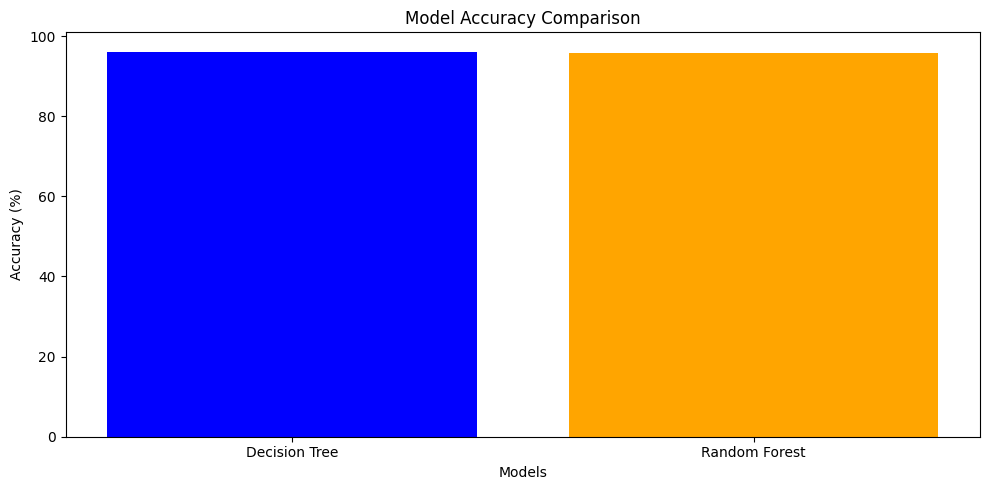

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel

# Load dataset
df = pd.read_csv("/content/datasets.csv")  # Replace with actual dataset path

# Drop rows with missing values
df.dropna(inplace=True)

# Convert categorical variables to strings before encoding
df = df.astype(str)

# Encoding categorical variables
categorical_cols = ["SEX", "SEASON", "CONTINENTS", "Skin Type (Fitzpatrick Scale)"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Convert all remaining columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values after conversion
df.dropna(inplace=True)

# Define features (X) and target variable (y)
X = df.drop(columns=["DV", "ID", "TIME"])
y = df["DV"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Feature Selection using Decision Tree (based on Gini Impurity)
selector = SelectFromModel(DecisionTreeRegressor(criterion="friedman_mse", random_state=42))
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Keep only selected feature names
selected_features = df.drop(columns=["DV", "ID", "TIME"]).columns[selector.get_support()]
print("Selected Features:", list(selected_features))

# Hyperparameter tuning for Decision Tree and Random Forest
param_distributions_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'splitter': ['best', 'random']
}

param_distributions_rf = {
    'n_estimators': [500, 800, 1000],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

dt_model = DecisionTreeRegressor(random_state=42, criterion="friedman_mse")  # Using Friedman MSE (like Gini)
rf_model = RandomForestRegressor(random_state=42, criterion="friedman_mse")

# RandomizedSearchCV for Decision Tree
random_search_dt = RandomizedSearchCV(
    dt_model, param_distributions_dt,
    n_iter=20, cv=3, scoring='neg_mean_absolute_error', n_jobs=2, random_state=42
)

random_search_dt.fit(X_train_selected, y_train)

# RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions_rf,
    n_iter=20, cv=3, scoring='neg_mean_absolute_error', n_jobs=2, random_state=42
)

random_search_rf.fit(X_train_selected, y_train)

# Best models
dt_best_model = random_search_dt.best_estimator_
rf_best_model = random_search_rf.best_estimator_

# Predictions for Decision Tree and Random Forest
dt_pred = dt_best_model.predict(X_test_selected)
rf_pred = rf_best_model.predict(X_test_selected)

# Evaluation Metrics
dt_mse = mean_squared_error(y_test, dt_pred)
rf_mse = mean_squared_error(y_test, rf_pred)

dt_mae = mean_absolute_error(y_test, dt_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

dt_r2 = r2_score(y_test, dt_pred)
rf_r2 = r2_score(y_test, rf_pred)

# Calculate accuracy percentage (R² * 100)
dt_accuracy = dt_r2 * 100
rf_accuracy = rf_r2 * 100

# Display Metrics
print(f"🔹 Decision Tree Accuracy: {dt_accuracy:.2f}%")
print(f"🔹 Random Forest Accuracy: {rf_accuracy:.2f}%")
print(f"🔹 Decision Tree MSE: {dt_mse:.4f}, MAE: {dt_mae:.4f}, R²: {dt_r2:.4f}")
print(f"🔹 Random Forest MSE: {rf_mse:.4f}, MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}")

# Feature Importance (for both models)
feature_importances_dt = pd.Series(dt_best_model.feature_importances_, index=selected_features)
feature_importances_rf = pd.Series(rf_best_model.feature_importances_, index=selected_features)

# Plotting Feature Importances
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
feature_importances_dt.sort_values().plot(kind='barh', title='Decision Tree Feature Importance')

plt.subplot(1, 2, 2)
feature_importances_rf.sort_values().plot(kind='barh', title='Random Forest Feature Importance')

plt.tight_layout()
plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test, dt_pred, label='Decision Tree', alpha=0.5)
plt.scatter(y_test, rf_pred, label='Random Forest', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel("Actual DV")
plt.ylabel("Predicted DV")
plt.title("Predicted vs Actual Vitamin D Levels")
plt.legend()
plt.show()

# Accuracy Comparison
models = ['Decision Tree', 'Random Forest']
accuracy_scores = [dt_accuracy, rf_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracy_scores, color=['blue', 'orange'])
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")

plt.tight_layout()
plt.show()
